In [10]:
from torchvision import transforms
from torch.utils.data import DataLoader
from src.products_dataset import ProductsDataset

import matplotlib.pyplot as plt

In [11]:
dataset = ProductsDataset(xlsx_filepath='./data/products.xlsx',
                          root_dir='./data/high-res-images',
                          transform=transforms.Compose([
                              transforms.Resize(500),
                              transforms.CenterCrop(500),
                          ]))

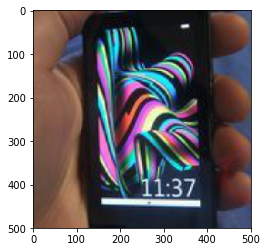

In [12]:
plt.imshow(dataset[1304]['image'])

In [13]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

In [16]:
for i, batch in enumerate(dataloader):
    print(len(batch['image']))
    
    if i == 4:
        break

16
16
16
16
16
